## Setup

In [0]:
# The code in this cell is only necessary when using Google Colab and storing 
# the data on Google Drive. If you don't use that combination, ignore it.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from hyperopt import hp, fmin, rand, tpe, space_eval, tpe, Trials
from os import listdir

print(tf.__version__)
print(np.__version__)
print('done')

1.14.0
1.16.4
done


In [0]:
# Replace this path with the path to the directory you want to save the files 
# produced by this notebook in.
notebook_dir = '/content/drive/My Drive/Colab Notebooks/3classes/finetuned/BA_CNN_Finetuned_Xception_Crossvalidation/'

# Replace these paths with the paths to the directories with your training 
# and testing data respectively.
# Each of the two directories should have three subdirectories named 'matrix',
# 'notype' and 'unpacking' with each subdirectory containing the images of the
# respective class.
train_data_dir = '/content/drive/My Drive/data3/train/'
test_data_dir = '/content/drive/My Drive/data3/validation/'

k_folds = 10
trial_id = 'first_trial'
nb_train_samples = 300
nb_test_samples = 30
epochs = 20
batch_size = 10

## Compute and save feature arrays

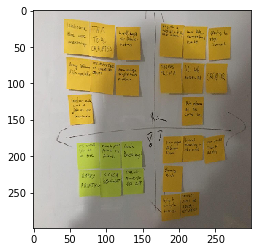

(299, 299, 3)
[1 0 0]
ndarray
ndarray


In [0]:
img_width, img_height = 299, 299

# loading datasets directly into memory beforehand - about 20 times faster when training
samples_x = []
samples_y = []
test_x = []
test_y = []

def add_class_from_dir(class_dir, label, data_x, data_y):
  class_samples = listdir(class_dir)
  for image in class_samples:
    img = load_img(path=class_dir + image, target_size=(img_height, img_width))
    data_x.append(img_to_array(img))
    data_y.append(label)

add_class_from_dir(class_dir=train_data_dir + 'matrix/', label=[1,0,0], data_x=samples_x, data_y=samples_y)
add_class_from_dir(class_dir=train_data_dir + 'notype/', label=[0,1,0], data_x=samples_x, data_y=samples_y)
add_class_from_dir(class_dir=train_data_dir + 'unpacking/', label=[0,0,1], data_x=samples_x, data_y=samples_y)

add_class_from_dir(class_dir=test_data_dir + 'matrix/', label=[1,0,0], data_x=test_x, data_y=test_y)
add_class_from_dir(class_dir=test_data_dir + 'notype/', label=[0,1,0], data_x=test_x, data_y=test_y)
add_class_from_dir(class_dir=test_data_dir + 'unpacking/', label=[0,0,1], data_x=test_x, data_y=test_y)

samples_x = np.array(samples_x)
test_x = np.array(test_x)
samples_y = np.array(samples_y)
test_y = np.array(test_y)

plt.figure()
plt.imshow(samples_x[0]/(255))
plt.show()
print(samples_x[0].shape)
print(samples_y[0])
print(type(samples_x).__name__)
print(type(test_x).__name__)

In [0]:
datagen = ImageDataGenerator(rescale=1. / 255)

# build the Xception network
model = applications.Xception(include_top=False, weights='imagenet')

generator = datagen.flow(
    samples_x,
    samples_y,
    batch_size=batch_size,
    shuffle=False)
bottleneck_features_train = model.predict_generator(
    generator, nb_train_samples // batch_size)
with open(notebook_dir + 'bottleneck_features_train3.npy', 'wb') as features_train_file:
    np.save(features_train_file, bottleneck_features_train)
print('done first half')

generator = datagen.flow(
    test_x,
    test_y,
    batch_size=batch_size,
    shuffle=False)
bottleneck_features_test = model.predict_generator(
    generator, nb_test_samples // batch_size)
with open(notebook_dir + 'bottleneck_features_validation3.npy', 'wb') as test_features_file:
    np.save(test_features_file, bottleneck_features_test)
    
keras.backend.clear_session()

print('done')

done first half
done


## Pre-train the top model

In [0]:
# data augmentation
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_data = np.load(open(notebook_dir + 'bottleneck_features_train3.npy', 'rb'))
train_labels = np.array(
    [0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3))
train_labels = to_categorical(train_labels)
test_data = np.load(open(notebook_dir + 'bottleneck_features_validation3.npy', 'rb'))
test_labels = np.array(
    [0] * (nb_test_samples // 3) + [1] * (nb_test_samples // 3) + [2] * (nb_test_samples // 3))
test_labels = to_categorical(test_labels)


#test_labels = np.array(test_labels)
#train_labels = np.array(train_labels)
#train_data = np.array(train_data)
#test_data = np.array(test_data)
#train_data = np.concatenate((train_data, test_data))
#train_labels = np.concatenate((train_labels, test_labels))

cross_validation_results = []
test_set_results = []
skf = StratifiedKFold(n_splits=k_folds, random_state=4, shuffle=True)
current_split = 0
for train_index, val_index in skf.split(train_data, list(map(lambda x: np.argmax(x), train_labels))):

  train_x, train_y = train_data[train_index], train_labels[train_index]
  val_x, val_y = train_data[val_index], train_labels[val_index]

  model = Sequential()
  model.add(Flatten(input_shape=train_data.shape[1:]))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))

  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy', metrics=['accuracy'])

  model.fit(train_x, train_y,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_x, val_y),
            verbose=0)

  model.save_weights(f'{notebook_dir}{trial_id}_split_{current_split}_topmodel_weights.h5')
  result = model.evaluate(val_x, val_y)
  # print(f'validation results for split {current_split}: {result}')
  cross_validation_results.append(result)

  current_split += 1
  
  keras.backend.clear_session()
##########

for i in cross_validation_results:
  print(i)

mean_val_acc = np.mean(list(map(lambda x: x[1], cross_validation_results)))
print(mean_val_acc)

W0806 13:54:05.737192 140487045846912 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


30/30 [==============================] - 0s 560us/sample - loss: 8.0354 - acc: 0.6667
[3.0905134677886963, 0.8333333]
[2.708970546722412, 0.8666667]
[5.879482746124268, 0.73333335]
[7.213661193847656, 0.7]
[8.037178993225098, 0.6666667]
[3.572514772415161, 0.76666665]
[4.014749526977539, 0.8]
[5.02400541305542, 0.73333335]
[4.787309169769287, 0.7]
[8.035420417785645, 0.6666667]
0.74666667


## Verify that splits for both training runs are the same

In [0]:
# making sure StratifiedKFold works as expected and returns consistent splits when reused

train_data = np.load(open(notebook_dir + 'bottleneck_features_train3.npy', 'rb'))
train_labels = np.array(
    [0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3))
train_labels = to_categorical(train_labels)
test_data = np.load(open(notebook_dir + 'bottleneck_features_validation3.npy', 'rb'))
test_labels = np.array(
    [0] * (nb_test_samples // 3) + [1] * (nb_test_samples // 3) + [2] * (nb_test_samples // 3))
test_labels = to_categorical(test_labels)

s = StratifiedKFold(n_splits=k_folds, random_state=4, shuffle=True)
split1 = []
for train, val in s.split(train_data, list(map(lambda x: np.argmax(x), train_labels))):
  split1.append(val)
  
split2 = []
for train, val in s.split(train_data, list(map(lambda x: np.argmax(x), train_labels))):
  split2.append(val)
  
print('split1:')
print(np.array(split1))
print('split2:')
print(np.array(split2))
print('both splits are equal:')
print(np.array_equal(split1, split2))

split1:
[[ 10  16  20  24  41  47  53  63  96  97 121 133 134 140 147 150 156 162
  188 196 210 213 218 232 234 235 246 260 291 295]
 [  2  13  14  26  29  35  37  43  54  95 101 106 114 138 145 176 177 180
  187 194 200 206 221 224 233 243 250 259 264 297]
 [  4   5  19  60  70  71  76  80  81  85 104 108 118 155 158 166 173 182
  192 199 214 226 236 238 245 251 263 267 268 288]
 [  7  18  27  39  61  62  65  75  78  88 112 126 144 153 154 168 181 183
  195 198 209 222 225 227 258 271 275 280 283 285]
 [  6  11  12  22  23  25  59  77  92  94 102 116 119 122 124 129 136 148
  161 178 201 203 212 217 252 261 269 273 290 292]
 [ 15  17  31  34  48  51  68  82  83  86 105 109 125 132 137 139 157 170
  171 191 207 211 216 239 247 256 276 281 286 287]
 [ 28  32  33  40  42  45  64  67  74  91 111 123 128 141 167 169 172 175
  184 193 202 205 228 231 241 242 270 274 298 299]
 [  8  21  30  49  56  66  73  79  84  99 103 120 130 131 135 151 165 174
  189 190 204 215 230 237 257 272 279 284 2

In [0]:
# making sure images are in the same order as features
np.array_equal(train_labels, samples_y)

True

## Finetune last convolutional block of base model

In [0]:
overall_cross_validation_results = []
current_split = 0
for train_index, val_index in skf.split(samples_x, list(map(lambda x: np.argmax(x), samples_y))):

  train_x, train_y = samples_x[train_index], samples_y[train_index]
  val_x, val_y = samples_x[val_index], samples_y[val_index]

  train_generator = train_datagen.flow(
      x=train_x,
      y=train_y,
      batch_size=batch_size)

  validation_generator = test_datagen.flow(
      x=val_x,
      y=val_y,
      batch_size=batch_size)
  
  test_generator = test_datagen.flow(
      x=test_x,
      y=test_y,
      batch_size=batch_size)
  
  base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
  
  top_model = Sequential()
  top_model.add(Flatten(input_shape=train_data.shape[1:]))
  top_model.add(Dense(256, activation='relu'))
  top_model.add(Dropout(0.5))
  top_model.add(Dense(3, activation='softmax'))

  top_model.load_weights(f'{notebook_dir}{trial_id}_split_{current_split}_topmodel_weights.h5')
  
  model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
  
  for layer in model.layers[:15]:
    layer.trainable = False
    
  model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
  
  model_checkpoint = ModelCheckpoint(filepath=f'{notebook_dir}{trial_id}_split_{current_split}_overall_weights_best.h5',
                                       monitor='val_acc',
                                       save_best_only=True,
                                       save_weights_only=True,
                                       verbose=1)
  
  model.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[model_checkpoint])
  
  result = model.evaluate(validation_generator)
  print(f'validation results for split {current_split}: {result}')
  model.save_weights(f'{notebook_dir}{trial_id}_split_{current_split}_overall_weights_final.h5')
  overall_cross_validation_results.append(result)
  current_split += 1
  
  keras.backend.clear_session()
  
# print results
for i in overall_cross_validation_results:
  print(i)

mean_val_acc = np.mean(list(map(lambda x: x[1], overall_cross_validation_results)))
print(f'mean val acc: {mean_val_acc}')
  

Epoch 1/10

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to /content/drive/My Drive/Colab Notebooks/3classes/fine-tuned/Xception/first_trial_split_0_overall_weights_best.h5
27/27 - 40s - loss: 15.5661 - acc: 0.4741 - val_loss: 12.4691 - val_acc: 0.5333
Epoch 2/10

Epoch 00002: val_acc did not improve from 0.53333
27/27 - 19s - loss: 1.1031 - acc: 0.5704 - val_loss: 2.7573 - val_acc: 0.5333
Epoch 3/10

Epoch 00003: val_acc improved from 0.53333 to 0.63333, saving model to /content/drive/My Drive/Colab Notebooks/3classes/fine-tuned/Xception/first_trial_split_0_overall_weights_best.h5
27/27 - 21s - loss: 0.9713 - acc: 0.5815 - val_loss: 1.2374 - val_acc: 0.6333
Epoch 4/10

Epoch 00004: val_acc improved from 0.63333 to 0.66667, saving model to /content/drive/My Drive/Colab Notebooks/3classes/fine-tuned/Xception/first_trial_split_0_overall_weights_best.h5
27/27 - 21s - loss: 0.9294 - acc: 0.6074 - val_loss: 0.9100 - val_acc: 0.6667
Epoch 5/10

Epoch 00005: val_acc did no